### Imports

In [1]:
import cv2
import time

import requests
import numpy as np
import matplotlib.pyplot as plt

from PIL import ImageFont, ImageDraw, Image

### helper functions

In [2]:
def detect_limbus(gray, return_all=False):
    circles = cv2.HoughCircles(
        cv2.GaussianBlur(255 - gray, ksize=(0,0), sigmaX=2),
        cv2.HOUGH_GRADIENT, dp=1, minDist=1,
        param1=50, param2=40,
        minRadius=gray.shape[0]//10, maxRadius=round(gray.shape[0]//1.5)
    )
    
    if circles is None:
        return None
    
    if return_all:
        return circles[0,:,:]

    return circles[0,0,:2], circles[0,0,2]

In [3]:
bioniko_height_p = 0.18
bioniko_width_p = 0.14
bioniko_aspect = 5.7
bioniko_font_factor = 1.35

def write_bioniko(height, color=0, background=255):
    bioniko = background*np.ones((height,round(height*bioniko_aspect)))
    pil_im = Image.fromarray(bioniko)
    draw = ImageDraw.Draw(pil_im)
    font = ImageFont.truetype('data/century-gothic-bold.ttf', size=round(height*bioniko_font_factor))
    draw.text((0,0), 'BIONIKO', color, font=font, anchor='lt')
    bioniko = np.array(pil_im).astype('uint8')

    return bioniko

def detect_bioniko(gray, limbus_center, limbus_radius, return_verbose=False):
    # TODO: use multiple polar coordinate images to avoid 'BIONIKO' being cut
    gray_polar = cv2.warpPolar(gray, (0, 0), tuple(limbus_center), limbus_radius, cv2.WARP_POLAR_LINEAR)
    gray_polar = cv2.rotate(gray_polar, cv2.ROTATE_90_CLOCKWISE)
    gray_polar = cv2.resize(gray_polar, (0, 0), fx=2.0, fy=1.0)
       
    bioniko_height = min(round(limbus_radius*bioniko_height_p), gray_polar.shape[0])
    bioniko = write_bioniko(bioniko_height, background=255)
    ccoeff_normed = cv2.matchTemplate(gray_polar, bioniko, cv2.TM_CCOEFF_NORMED)
    _, max_val, _, max_loc = cv2.minMaxLoc(ccoeff_normed)
    
    cv2.drawMarker(ccoeff_normed, max_loc, 255)
    cv2.line(gray_polar, (max_loc[0],0), (max_loc[0],gray_polar.shape[0]-1), 255, 1)
    gray_polar[max_loc[1]:(max_loc[1]+bioniko.shape[0]),max_loc[0]:(max_loc[0]+bioniko.shape[1])] = bioniko
    cv2.putText(gray_polar, ' %s; %s' % (max_loc, max_val), (0,gray_polar.shape[0]-1) , cv2.FONT_HERSHEY_SIMPLEX, 1, 0)
    
    rad = 2*np.pi*max_loc[0]/gray_polar.shape[1]
    loc = limbus_radius*np.array([np.cos(rad), -np.sin(rad)])
    loc += limbus_center
    
    if return_verbose:
        return loc, gray_polar, ccoeff_normed
    
    return loc

In [4]:
def get_avg_laplacian(laplacian, center, radius):
    mask = np.zeros(laplacian.shape, dtype=np.byte)
    cv2.circle(mask, center, radius, 1)
    return np.mean(np.abs(laplacian[mask == 1]))

In [5]:
red_llth = np.array([150, 90, 60])
red_luth = np.array([179, 240, 230])
red_ulth = np.array([0, 90, 60])
red_uuth = np.array([15, 240, 230])

green_lth = np.array([40, 40, 75])
green_uth = np.array([100, 240, 230])

# blue_lth = np.array([110, 40, 25])
# blue_uth = np.array([160, 240, 190])
blue_lth = np.array([110, 25, 75])
blue_uth = np.array([160, 165, 190])

black_lth = np.array([0, 0, 0])
black_uth = np.array([179, 40, 170])

def segment_color(hsv, color):
    if color == 'red':
        red_l = cv2.inRange(hsv, red_llth, red_luth)
        red_u = cv2.inRange(hsv, red_ulth, red_uuth)
        result = cv2.bitwise_or(red_l, red_u)        
    elif color == 'green':
        result = cv2.inRange(hsv, green_lth, green_uth)
    elif color == 'blue':
        result = cv2.inRange(hsv, blue_lth, blue_uth)
    elif color == 'black':
        result = cv2.inRange(hsv, black_lth, black_uth)
    else:
        raise ValueError('unknown color: %s' % color)
    
    return result

In [6]:
def stack_vertical(strips, split=0.25):
    width = strips[0].shape[1]
    height = strips[0].shape[0]
    result = np.zeros((height*len(strips),width))
    for i, strip in enumerate(strips):
        split_th = round((i*split % 1.0) * width)
        result[i*height:(i+1)*height,width-split_th:] = strip[:,0:split_th]
        result[i*height:(i+1)*height,:width-split_th] = strip[:,split_th:]
    
    return result

In [7]:
sclera_to_limbus_ratio = 1.7
planar_sclera_to_limbus_ratio = 1.25
moment_decider = 'mu02'

def detect_markers_hu_moments(hsv, limbus_center, limbus_radius, return_verbose=False):
    hsv_polar = cv2.warpPolar(
        hsv,
        (0, 0),
        tuple(limbus_center),
        limbus_radius*planar_sclera_to_limbus_ratio,
        cv2.WARP_POLAR_LINEAR+cv2.WARP_FILL_OUTLIERS
    )
    hsv_polar = cv2.rotate(hsv_polar, cv2.ROTATE_90_CLOCKWISE)
    hsv_polar = cv2.resize(hsv_polar, (0, 0), fx=2.0, fy=1.0)
    hsv_polar = hsv_polar[round(limbus_radius):,:]
    
    red_polar = segment_color(hsv_polar, 'red')
    green_polar = segment_color(hsv_polar, 'green')
    blue_polar = segment_color(hsv_polar, 'blue')
    black_polar = segment_color(hsv_polar, 'black')
    black_polar[:,:] = 0 # TODO: needs better color segmentation
    
    colors_stacked = stack_vertical((
        green_polar, black_polar, red_polar, blue_polar))
#     colors_stacked = stack_vertical((
#         red_polar, blue_polar, green_polar, black_polar))

    window_width = round(10*colors_stacked.shape[1]/360)
    moments = []
    for i in range(360):
        window_center = round(i*colors_stacked.shape[1]/360)
        window = colors_stacked[
            :,
            max(0, window_center-window_width//2):min(colors_stacked.shape[1],window_center+window_width//2)
        ]
        moments.append(cv2.moments(window, binaryImage=True))
        
    moments = np.array([
        moment[moment_decider] for moment in moments
    ])
    
    max_deg = np.argmax(moments)
    rad = 2*np.pi*max_deg/moments.size
    loc = limbus_radius*np.array([np.cos(rad), -np.sin(rad)])
    loc += limbus_center
    
    if return_verbose:
        vis = cv2.cvtColor(colors_stacked.astype('uint8'), cv2.COLOR_GRAY2BGR)
        cv2.putText(vis, 'green', (0,round(vis.shape[0]*0.00 + 10)), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0))
        cv2.putText(vis, 'black', (0,round(vis.shape[0]*0.25 + 10)), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0))
        cv2.putText(vis, 'red', (0,round(vis.shape[0]*0.50 + 10)), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0))
        cv2.putText(vis, 'blue', (0,round(vis.shape[0]*0.75 + 10)), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0))
        return loc, vis, (green_polar, black_polar, red_polar, blue_polar)
    
    return loc

In [8]:
sclera_to_limbus_ratio = 1.7
planar_sclera_to_limbus_ratio = 1.25
entropy_eps = np.log(0.7)

def detect_markers_entropy(hsv, limbus_center, limbus_radius, return_verbose=False):
    hsv_polar = cv2.warpPolar(
        hsv,
        (115, 720),
        tuple(limbus_center),
        limbus_radius*sclera_to_limbus_ratio,
        cv2.WARP_POLAR_LINEAR+cv2.WARP_FILL_OUTLIERS
    )
    hsv_polar = cv2.rotate(hsv_polar, cv2.ROTATE_90_CLOCKWISE)
    hsv_polar = hsv_polar[70:,:]
    
    red_polar = segment_color(hsv_polar, 'red')
    green_polar = segment_color(hsv_polar, 'green')
    blue_polar = segment_color(hsv_polar, 'blue')
#     black_polar = segment_color(hsv_polar, 'black')
#     black_polar[:,:] = 0 # TODO: needs better color segmentation
    
    colors_stacked = stack_vertical((red_polar, blue_polar, green_polar))
#     colors_stacked = stack_vertical((
#         red_polar, blue_polar, green_polar, black_polar))

    window_width = round(10*colors_stacked.shape[1]/360)
    colors_stacked_aug = np.zeros((
        colors_stacked.shape[0],
        colors_stacked.shape[1]+window_width
    ))
    colors_stacked_aug[:,window_width//2:colors_stacked_aug.shape[1]-window_width//2] = colors_stacked
    colors_stacked_aug[:,:window_width//2] = colors_stacked[:,colors_stacked.shape[1]-window_width//2:]
    colors_stacked_aug[:,colors_stacked_aug.shape[1]-window_width//2:] = colors_stacked[:,:window_width//2]
    entropy = []
    for i in range(360):
        window_center = round(i*colors_stacked.shape[1]/360)
        window = colors_stacked_aug[:,(window_center-window_width//2):(window_center+window_width//2+1)]           
        
        values = np.sum(window, axis=1)
        values = values[values != 0]
        if values.shape[0] == 0:
            entropy.append(0)
            continue

        values = values / np.sum(values)
        entropy.append(np.sum(np.multiply(-values, np.log(values))))
        
    entropy = np.array(entropy)
    max_entropy = np.max(entropy)
    optimal_degs = np.where(entropy > (max_entropy + entropy_eps))
    optimal_deg = np.median(optimal_degs)
#     print(optimal_deg, optimal_degs)
    
    rad = 2*np.pi*optimal_deg/entropy.size
    loc = limbus_radius*np.array([np.cos(rad), -np.sin(rad)])
    loc += limbus_center
    
    if return_verbose:
        vis = cv2.cvtColor(colors_stacked.astype('uint8'), cv2.COLOR_GRAY2BGR)
        cv2.putText(vis, 'red', (0,round(vis.shape[0]*0.00 + 10)), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0))
        cv2.putText(vis, 'blue', (0,round(vis.shape[0]*0.33 + 10)), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0))
        cv2.putText(vis, 'green', (0,round(vis.shape[0]*0.66 + 10)), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0))
        return loc, vis, (red_polar, blue_polar, green_polar)
    
    return loc

In [56]:
def get_mean_intensity(grey, center, radius, width_to_radius_ratio=0.05, mode='out'):
    assert mode in ('in', 'out', 'filled'), 'mode %s is not supported' % mode
     
    mask = np.zeros(grey.shape, dtype=np.byte)
    width = int(width_to_radius_ratio*radius)
    
    if mode == 'in':
        cv2.circle(mask, center, radius - (width//2), 1, thickness=width)
    elif mode == 'out':
        cv2.circle(mask, center, radius + (width//2), 1, thickness=width)
    elif mode == 'filled':
        cv2.circle(mask, center, radius, 1, thickness=cv2.FILLED)
    return np.mean(grey[mask == 1])

In [31]:
def get_in_out_intensity_diff(grey, center, radius, circle_width_to_radius_ratio=0.04, metric='in_out'):
    circle_width = int(circle_width_to_radius_ratio*radius)
    
    mask = np.zeros(grey.shape, dtype=np.byte)
    cv2.circle(mask, center, radius - (circle_width//2), 1, thickness=circle_width)
    in_intensity = np.mean(grey[mask == 1])
    
    mask = np.zeros(grey.shape, dtype=np.byte)
    cv2.circle(mask, center, radius + (circle_width//2), 1, thickness=circle_width)
    out_intensity = np.mean(grey[mask == 1])
    
    assert metric in ('in_out', 'out_in'), 'metric %s is not supported' % metric
    
    if metric == 'in_out':
        return out_intensity - in_intensity
    elif metric == 'out_in':
        return in_intensity - out_intensity
    
    return None

In [39]:
def get_circle_in_strip_out_intensity_diff(grey, center, radius, strip_width_to_radius_ratio=0.04, metric='in_out'):
    strip_width = int(strip_width_to_radius_ratio*radius)

    mask = np.zeros(grey.shape, dtype=np.byte)
    cv2.circle(mask, center, radius, 1, thickness=cv2.FILLED)
    in_intensity = np.mean(grey[mask == 1])
    
    mask = np.zeros(grey.shape, dtype=np.byte)
    cv2.circle(mask, center, radius + (strip_width//2), 1, thickness=strip_width)
    out_intensity = np.mean(grey[mask == 1])
    
    assert metric in ('in_out', 'out_in'), 'metric %s is not supported' % metric
    
    if metric == 'in_out':
        return out_intensity - in_intensity
    elif metric == 'out_in':
        return in_intensity - out_intensity
    
    return None

### 1. video demo playback

In [19]:
cap = cv2.VideoCapture('data/artificial/procedure4_lofi.mkv')

while cap.isOpened():
    ret, frame = cap.read() 
  
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
  
    circles = cv2.HoughCircles(
        cv2.GaussianBlur(255 - gray, ksize=(0,0), sigmaX=2),
        cv2.HOUGH_GRADIENT, dp=1, minDist=1,
        param1=120, param2=40,
        minRadius=gray.shape[0]//10, maxRadius=round(gray.shape[0]/1.2)
    )
    
    if circles is not None:
        circles_filtered = np.uint16(np.around(circles[0,:1,:]))
        for i, circle in enumerate(circles_filtered):
            cv2.circle(frame, (circle[0], circle[1]), circle[2], (0, 255, 0), 1)
            cv2.putText(frame, str(i + 1), (circle[0], circle[1]), cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 0), 1)
  
    cv2.imshow('original', frame)

    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 2. video demo capture

In [36]:
cap = cv2.VideoCapture('data/artificial/procedure3_lofi.mkv')
out = cv2.VideoWriter('test.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30,
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

while cap.isOpened():
    ret, frame = cap.read() 
    if ret == False:
        break
  
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
  
    circles = cv2.HoughCircles(
        cv2.GaussianBlur(255 - gray, ksize=(0,0), sigmaX=2),
        cv2.HOUGH_GRADIENT, dp=1, minDist=10,
        param1=120, param2=40,
        minRadius=gray.shape[0]//10, maxRadius=int(gray.shape[0]/1.5)
    )
    
    if circles is not None:
        circles_filtered = np.uint16(np.around(circles[0,:1,:]))
        for i, circle in enumerate(circles_filtered):
            cv2.circle(frame, (circle[0], circle[1]), circle[2], (0, 255, 0), 1)
            cv2.drawMarker(frame, (circle[0], circle[1]), (0, 255, 0))
  
    out.write(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cap.release()
out.release()                      
cv2.destroyAllWindows() 

### 3. realtime demo

In [ ]:
url = 'http://192.168.0.207:8080/shot.jpg'

while True:
    response = requests.get(url)
    img_arr = np.array(bytearray(response.content), dtype=np.uint8)
    img = cv2.imdecode(img_arr, -1)
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  
    circles = cv2.HoughCircles(
        cv2.GaussianBlur(255 - img_gray, ksize=(0,0), sigmaX=2),
        cv2.HOUGH_GRADIENT, dp=1, minDist=10,
        param1=120, param2=40,
        minRadius=img_gray.shape[0]//10, maxRadius=img_gray.shape[0]//2
    )
    
    if circles is not None:
        circles_filtered = np.uint16(np.around(circles[0,:1,:]))
        for i, circle in enumerate(circles_filtered):
            cv2.circle(img, (circle[0], circle[1]), circle[2], (0, 255, 0), 1)
            cv2.drawMarker(img, (circle[0], circle[1]), (0, 255, 0))
    
    cv2.imshow('android', img)

    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cv2.destroyAllWindows() 

### 4. video demo with smoothing

In [12]:
window_size = 30
scale = 0.25

cap = cv2.VideoCapture('data/artificial/procedure1.mp4')

frame_num = 0
window_circles = np.zeros((window_size,3))
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
  
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=scale, fy=scale)
  
    circles = cv2.HoughCircles(
        cv2.GaussianBlur(255 - gray, ksize=(0,0), sigmaX=2),
        cv2.HOUGH_GRADIENT, dp=1, minDist=10,
        param1=120, param2=40,
        minRadius=gray.shape[0]//10, maxRadius=gray.shape[0]
    )
    
    if circles is not None:
        circles *= (1/scale)
        if frame_num == 0:
            window_circles[:,:] = circles[0,0,:]
        else:
            window_circles[frame_num % window_size,:] = circles[0,0,:]
        frame_num += 1
        
    smoothed_circle = np.mean(window_circles, axis=0)
    smoothed_circle = np.uint16(np.around(smoothed_circle))

    cv2.circle(frame, (smoothed_circle[0], smoothed_circle[1]),
        smoothed_circle[2], (0, 255, 0), 1)
    cv2.drawMarker(frame, (smoothed_circle[0], smoothed_circle[1]),
        (0, 255, 0))

    cv2.imshow('original', frame)

    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 5. video demo with pupil and orientation

In [35]:
cap = cv2.VideoCapture('data/artificial/procedure3_lofi.mkv')

while cap.isOpened():
    ret, base = cap.read()
    base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY) 
  
    iris_circles = cv2.HoughCircles(
        cv2.GaussianBlur(255 - base_gray, ksize=(0,0), sigmaX=2),
        cv2.HOUGH_GRADIENT, dp=1, minDist=10,
        param1=120, param2=40,
        minRadius=base_gray.shape[0]//10, maxRadius=base_gray.shape[0]//2
    )
    
    if iris_circles is not None:
        # limbus
        iris_circle = np.uint16(np.around(iris_circles[0,0,:]))
        cv2.circle(base, (iris_circle[0], iris_circle[1]), iris_circle[2], (0, 255, 0), 1)
        cv2.drawMarker(base, (iris_circle[0], iris_circle[1]), (0, 255, 0))
        
        # pupil
        iris_pupil_mask = np.zeros(base.shape[:2], dtype=np.uint8)
        cv2.circle(iris_pupil_mask, (iris_circle[0], iris_circle[1]), iris_circle[2] - 20, 255, cv2.FILLED)

        base_gray_blur = cv2.GaussianBlur(base_gray, ksize=(0,0), sigmaX=2)
        base_roi_values = base_gray_blur[np.where(iris_pupil_mask == 255)]
        thres_otsu, _ = cv2.threshold(
            src=base_roi_values,
            thresh=0,
            maxval=255,
            type=cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU
        )

        base_gray_roi_thres = base_gray_blur.copy()
        base_gray_roi_thres[np.where(base_gray_roi_thres > thres_otsu)] = 255
        base_gray_roi_thres[np.where(base_gray_roi_thres <= thres_otsu)] = 0
        base_gray_roi_thres[np.where(iris_pupil_mask == 0)[0],np.where(iris_pupil_mask == 0)[1]] = 255//2

        base_pupil_gray = base_gray_blur.copy()
        base_pupil_gray[np.where(base_gray_roi_thres > thres_otsu)] = 255
        base_pupil_gray[np.where(base_gray_roi_thres <= thres_otsu)] = 0
        base_pupil_gray[np.where(iris_pupil_mask == 0)[0],np.where(iris_pupil_mask == 0)[1]] = 0
        pupil_circles = cv2.HoughCircles(
            cv2.GaussianBlur(base_pupil_gray, ksize=(0,0), sigmaX=2),
            cv2.HOUGH_GRADIENT, dp=1, minDist=10,
            param1=150, param2=1,
            minRadius=base_pupil_gray.shape[0]//10, maxRadius=int((7/10)*iris_circle[2])
        )
        
        if pupil_circles is not None:
            pupil_circle = np.uint16(np.around(pupil_circles[0,0,:]))

            cv2.circle(base, (pupil_circle[0], pupil_circle[1]), pupil_circle[2], (0, 255, 0), 1)

            # orientation
            thresh_percentage = 0.01
            
            iris_mask = iris_pupil_mask.copy()
            cv2.circle(iris_mask, (pupil_circle[0], pupil_circle[1]), pupil_circle[2], 0, cv2.FILLED)
            iris_values = base_gray[np.where(iris_mask == 255)[0],np.where(iris_mask == 255)[1]]
            
            low_thres = np.sort(iris_values)[int(thresh_percentage * iris_values.size)]
            iris_low = base_gray.copy()
            _, iris_low = cv2.threshold(iris_low, thresh=low_thres, maxval=255, type=cv2.THRESH_BINARY_INV)
            iris_low = cv2.bitwise_and(iris_low, iris_mask)
            
            kernel = np.ones((2,2), dtype=np.uint8)

            morphed = iris_low.copy()
            morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel, iterations=1)
            morphed = cv2.dilate(morphed, kernel, iterations=10)

            iris_center = np.array((iris_circle[0], iris_circle[1]))

            bioniko_center = np.mean(np.array(np.where(morphed == 255)), axis=1)
            bioniko_center = np.uint16(np.flip(bioniko_center))

            orientation = bioniko_center - iris_center
            start_point = iris_center + orientation
            end_point = iris_center - orientation

            cv2.drawMarker(base, tuple(bioniko_center), (0, 255, 0))
            cv2.line(
                base,
                tuple(start_point),
                tuple(end_point),
                [0, 255, 0], thickness=2
            )
        

    cv2.imshow('result', base)
    cv2.imshow('pupil', base_pupil_gray)
    cv2.imshow('bioniko marker thresholded', iris_low)
    cv2.imshow('bioniko marker morphed', morphed)

    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

/home/miroslav/Documents/tum/.venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/miroslav/Documents/tum/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


### 6. video demo with cross-correlation based orientation detection

In [20]:
cap = cv2.VideoCapture('data/artificial/procedure4_lofi.mkv')

base_polar = None
base_ccoef = None
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    ret = detect_limbus(base_value)
    if ret is not None:
        limbus_center, limbus_radius = ret
        bioniko_loc, base_polar, base_ccoef = detect_bioniko(
            base_value, limbus_center, limbus_radius, return_verbose=True)
        
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        bioniko_loc_t = tuple(np.around(bioniko_loc).astype('int'))
        
        # overlay
        cv2.drawMarker(base, limbus_center_t, (0,255,0))
        cv2.circle(base, limbus_center_t, round(limbus_radius), (0,255,0))
        cv2.line(base, limbus_center_t, bioniko_loc_t, (0,255,0))

    cv2.imshow('result', base)
    cv2.imshow('base polar', base_polar)
    cv2.imshow('base sqdiff', base_ccoef)

    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

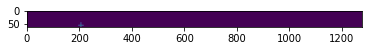

In [9]:
plt.imshow(base_sqdiff)

### 7. limbus validation using laplacian image

In [25]:
cap = cv2.VideoCapture('data/artificial/procedure1.mp4')

base_polar = None
base_sqdiff = None
arg_maxima = []
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    base_laplacian = cv2.Laplacian(base_value, cv2.CV_16S)
    
    circles = detect_limbus(base_value, return_all=True)
    
    if circles is not None:
        avg_laplacians = np.zeros(circles.shape[0])
        for index, circle in enumerate(circles):
            limbus_center = tuple(np.round(circle[:2]).astype('int'))
            limbus_radius = round(circle[2])
            avg_laplacians[index] = get_avg_laplacian(base_laplacian, limbus_center, limbus_radius)
        best_circle = circles[np.argmax(avg_laplacians),:]

        # overlays
        cv2.circle(base, tuple(np.round(circles[0,:2]).astype('int')), round(circles[0,2]), (0,255,0))
        cv2.circle(base, tuple(np.round(best_circle[:2]).astype('int')), round(best_circle[2]), (255,0,0))
        cv2.putText(
            base,
            'l(%d) = %f' % (np.argmax(avg_laplacians), np.max(avg_laplacians)),
            (0,base.shape[0]-1), 
            cv2.FONT_HERSHEY_PLAIN, 
            2, 
            (255,0,0)
        )
        
        arg_maxima.append(np.argmax(avg_laplacians))
        
    cv2.imshow('base', base)
#     cv2.imshow('base value', base_value)
#     cv2.imshow('base laplacian', cv2.convertScaleAbs(base_laplacian))
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 8. Orientation detection using color markers

In [18]:
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')

colors_stacked = None
colors_polar = None
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    ret = detect_limbus(base_value)
    if ret is not None:
        limbus_center, limbus_radius = ret
        zero_deg_loc, markers_vis, colors_polar = detect_markers_hu_moments(
            base_hsv, limbus_center, limbus_radius, return_verbose=True)
        
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        zero_deg_loc_t = tuple(np.around(zero_deg_loc).astype('int'))
        
        # overlay
        cv2.drawMarker(base, limbus_center_t, (0,255,0))
        cv2.circle(base, limbus_center_t, round(limbus_radius), (0,255,0))
        cv2.line(base, limbus_center_t, zero_deg_loc_t, (0,255,0))

    cv2.imshow('result', base)
    cv2.imshow('markers vis', markers_vis)
#     cv2.imshow('green', colors_polar[0])
#     cv2.imshow('black', colors_polar[1])
#     cv2.imshow('red', colors_polar[2])
#     cv2.imshow('blue', colors_polar[3])
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

In [35]:
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')

colors_stacked = None
colors_polar = None
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    ret = detect_limbus(base_value)
    if ret is not None:
        limbus_center, limbus_radius = ret
        zero_deg_loc, markers_vis, colors_polar = detect_markers_entropy(
            base_hsv, limbus_center, limbus_radius, return_verbose=True)
        
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        zero_deg_loc_t = tuple(np.around(zero_deg_loc).astype('int'))
        
        # overlay
        cv2.drawMarker(base, limbus_center_t, (0,255,0))
        cv2.circle(base, limbus_center_t, round(limbus_radius), (0,255,0))
        cv2.line(base, limbus_center_t, zero_deg_loc_t, (0,255,0))

    cv2.imshow('result', base)
    cv2.imshow('markers vis', markers_vis)
#     cv2.imshow('green', colors_polar[0])
#     cv2.imshow('black', colors_polar[1])
#     cv2.imshow('red', colors_polar[2])
#     cv2.imshow('blue', colors_polar[3])
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
7.0 (array([5, 6, 7, 8, 9]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
7.5 (array([ 5,  6,  7,  8,  9, 10]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
7.5 (array([ 5,  6,  7,  8,  9, 10]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.0 (array([5, 6, 7]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
7.5 (array([ 5,  6,  7,  8,  9, 10]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)
7.5 (array([ 5,  6,  7,  8,  9, 10]),)
7.0 (array([5, 6, 7, 8, 9]),)
6.0 (array([5, 6, 7]),)
6.5 (array([5, 6, 7, 8]),)
6.5 (array([5, 6, 7, 8]),)


### 9. Outer limbus edge detection with low mean intensity based validation

In [18]:
considered_circles_ratio_init = 0.03

cap = cv2.VideoCapture('data/artificial/procedure3_lofi.mkv')

while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_best_hough = base.copy()
    base_validated_hough = base.copy()
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    circles = detect_limbus(base_value, return_all=True)
    if circles is not None:
        # hough w/o validation
        best_circle = circles[0]
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_best_hough, limbus_center_t, round(limbus_radius), (0,0,255), 2)
        cv2.putText(base_best_hough, 'circle index: 0', (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255))
        
        # hough w/ validation
        considered_circles_ratio = considered_circles_ratio_init
        considered_circles = []
        while len(considered_circles) == 0:
            considered_circles = circles[:int(len(circles)*considered_circles_ratio)]
            considered_circles_ratio *= 2
        
        in_out_diff_intensities = np.zeros(len(considered_circles))
        for index, circle in enumerate(considered_circles):
            in_out_diff_intensities[index] = get_in_out_intensity_diff(
                base_value,
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int')
            )
            
        best_circle_index = np.argmax(in_out_diff_intensities)
        best_circle = considered_circles[best_circle_index]
        
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_radius), (0,255,0), 2)
        cv2.putText(base_validated_hough, 'circle index: %d' % best_circle_index, (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        
        cv2.putText(base_validated_hough, 'circls processed: %d' % len(considered_circles), (0,60) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))

    cv2.imshow('w/o validation', base_best_hough)
    cv2.imshow('w/ validation', base_validated_hough)
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 10. Outer limbus edge detection with high-low mean intensity based validation

In [114]:
considered_circles_ratio_init = 0.03
window_size = 5

cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')

window = []
i = 0
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_best_hough = base.copy()
    base_validated_hough = base.copy()
    base_smoothed_hough = base.copy()
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    circles = detect_limbus(base_value, return_all=True)
    if circles is not None:
        # hough w/o validation
        best_circle = circles[0]
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_best_hough, limbus_center_t, round(limbus_radius), (0,0,255), 2)
        cv2.putText(base_best_hough, 'circle index: 0', (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255))
        
        # hough w/ validation
        considered_circles_ratio = considered_circles_ratio_init
        considered_circles = []
        while len(considered_circles) == 0:
            considered_circles = circles[:int(len(circles)*considered_circles_ratio)]
            considered_circles_ratio *= 2
        
        in_out_diff_intensities = np.zeros(len(considered_circles))
        for index, circle in enumerate(considered_circles):
            in_out_diff_intensities[index] = get_in_out_intensity_diff(
                base_value,
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int')
            )
            
        best_circle_index = np.argmax(in_out_diff_intensities)
        best_circle = considered_circles[best_circle_index]
        
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_radius), (0,255,0), 2)
        cv2.putText(base_validated_hough, 'circle index: %d' % best_circle_index, (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        cv2.putText(base_validated_hough, 'circls processed: %d' % len(considered_circles), (0,60) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        
        # hough w/ validation and smoothing
        if i < window_size:
            window.append(best_circle)
        else:
            window[i % window_size] = best_circle
        i += 1
            
        best_circle = np.mean(np.array(window), axis=0)
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_smoothed_hough, limbus_center_t, round(limbus_radius), (255,0,0), 2)

    cv2.imshow('w/o validation', base_best_hough)
    cv2.imshow('w/ validation', base_validated_hough)
    cv2.imshow('w/ validation and smoothing', base_smoothed_hough)
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 11. Outer limbus edge detection with high-low mean intensity based validation with fps counter

In [40]:
considered_circles_ratio_init = 0.03
window_size = 5
frame_rate = 30

cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')

window = []
window_num = 0
prev_time = 0
while cap.isOpened():
    time_elapsed = time.time() - prev_time
#     print(1/time_elapsed)
    
    ret, base = cap.read()
    if not ret:
        break
    
    base_best_hough = base.copy()
    base_validated_hough = base.copy()
    base_smoothed_hough = base.copy()
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    circles = detect_limbus(base_value, return_all=True)
    if circles is not None:
        # hough w/o validation
        best_circle = circles[0]
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_best_hough, limbus_center_t, round(limbus_radius), (0,0,255), 2)
        cv2.putText(base_best_hough, 'circle index: 0', (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255))
        
        # hough w/ validation
        considered_circles_ratio = considered_circles_ratio_init
        considered_circles = []
        while len(considered_circles) == 0:
            considered_circles = circles[:int(len(circles)*considered_circles_ratio)]
            considered_circles_ratio *= 2
        
        in_out_diff_intensities = np.zeros(len(considered_circles))
        for index, circle in enumerate(considered_circles):
            in_out_diff_intensities[index] = get_in_out_intensity_diff(
                base_value,
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int')
            )
            
        best_circle_index = np.argmax(in_out_diff_intensities)
        best_circle = considered_circles[best_circle_index]
        
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_radius), (0,255,0), 2)
        cv2.putText(base_validated_hough, 'circle index: %d' % best_circle_index, (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        cv2.putText(base_validated_hough, 'circls processed: %d' % len(considered_circles), (0,60) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        
        # hough w/ validation and smoothing
        if window_num < window_size:
            window.append(best_circle)
        else:
            window[window_num % window_size] = best_circle
        window_num += 1
            
        best_circle = np.mean(np.array(window), axis=0)
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_smoothed_hough, limbus_center_t, round(limbus_radius), (255,0,0), 2)

    cv2.imshow('w/o validation', base_best_hough)
    cv2.imshow('w/ validation', base_validated_hough)
    cv2.imshow('w/ validation and smoothing', base_smoothed_hough)

    prev_time = time.time()
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 12. Outer limbus edge detection with high-low mean intensity based validation with color marker detection

In [32]:
considered_circles_ratio_init = 0.03
window_size = 5
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')

window = []
window_num = 0
colors_stacked = None
colors_polar = None
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_best_hough = base.copy()
    base_validated_hough = base.copy()
    base_smoothed_hough = base.copy()
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    circles = detect_limbus(base_value, return_all=True)
    if circles is not None:
        # hough w/o validation
        best_circle = circles[0]
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_best_hough, limbus_center_t, round(limbus_radius), (0,0,255), 2)
        cv2.putText(base_best_hough, 'circle index: 0', (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255))
        
        zero_deg_loc, markers_vis, colors_polar = detect_markers_entropy(
            base_hsv, limbus_center, limbus_radius, return_verbose=True)
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        zero_deg_loc_t = tuple(np.around(zero_deg_loc).astype('int'))
        cv2.drawMarker(base_best_hough, limbus_center_t, (0,0,255))
        cv2.circle(base_best_hough, limbus_center_t, round(limbus_radius), (0,0,255))
        cv2.line(base_best_hough, limbus_center_t, zero_deg_loc_t, (0,0,255))
        
        # hough w/ validation
        considered_circles_ratio = considered_circles_ratio_init
        considered_circles = []
        while len(considered_circles) == 0:
            considered_circles = circles[:int(len(circles)*considered_circles_ratio)]
            considered_circles_ratio *= 2
        
        in_out_diff_intensities = np.zeros(len(considered_circles))
        for index, circle in enumerate(considered_circles):
            in_out_diff_intensities[index] = get_in_out_intensity_diff(
                base_value,
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int')
            )
            
        best_circle_index = np.argmax(in_out_diff_intensities)
        best_circle = considered_circles[best_circle_index]
        
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_radius), (0,255,0), 2)
        cv2.putText(base_validated_hough, 'circle index: %d' % best_circle_index, (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        cv2.putText(base_validated_hough, 'circls processed: %d' % len(considered_circles), (0,60) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        
        zero_deg_loc, markers_vis, colors_polar = detect_markers_entropy(
            base_hsv, limbus_center, limbus_radius, return_verbose=True)
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        zero_deg_loc_t = tuple(np.around(zero_deg_loc).astype('int'))
        cv2.drawMarker(base_validated_hough, limbus_center_t, (0,255,0))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_radius), (0,255,0))
        cv2.line(base_validated_hough, limbus_center_t, zero_deg_loc_t, (0,255,0))
        
        # hough w/ validation and smoothing
        if window_num < window_size:
            window.append(best_circle)
        else:
            window[window_num % window_size] = best_circle
        window_num += 1
            
        best_circle = np.mean(np.array(window), axis=0)
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_smoothed_hough, limbus_center_t, round(limbus_radius), (255,0,0), 2)
        
        zero_deg_loc, markers_vis, colors_polar = detect_markers_entropy(
            base_hsv, limbus_center, limbus_radius, return_verbose=True)
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        zero_deg_loc_t = tuple(np.around(zero_deg_loc).astype('int'))
        cv2.drawMarker(base_smoothed_hough, limbus_center_t, (255,0,0))
        cv2.circle(base_smoothed_hough, limbus_center_t, round(limbus_radius), (255,0,0))
        cv2.line(base_smoothed_hough, limbus_center_t, zero_deg_loc_t, (255,0,0))

    cv2.imshow('w/o validation', base_best_hough)
    cv2.imshow('w/ validation', base_validated_hough)
    cv2.imshow('w/ validation and smoothing', base_smoothed_hough)
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 13. Outer limbus edge detection with high-low mean intensity based validation with color marker detection (capture)

In [44]:
considered_circles_ratio_init = 0.03
window_size = 5
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')

best_hough_out = cv2.VideoWriter('best_hough.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30,
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))
validated_hough_out = cv2.VideoWriter('validated_hough.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30,
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))
smoothed_hough_out = cv2.VideoWriter('smoothed_hough.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30,
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

window = []
window_num = 0
colors_stacked = None
colors_polar = None
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_best_hough = base.copy()
    base_validated_hough = base.copy()
    base_smoothed_hough = base.copy()
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:,:,2]
    
    circles = detect_limbus(base_value, return_all=True)
    if circles is not None:
        # hough w/o validation
        best_circle = circles[0]
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_best_hough, limbus_center_t, round(limbus_radius), (0,0,255), 2)
        cv2.putText(base_best_hough, 'circle index: 0', (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255))
        
        zero_deg_loc, markers_vis, colors_polar = detect_markers_entropy(
            base_hsv, limbus_center, limbus_radius, return_verbose=True)
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        zero_deg_loc_t = tuple(np.around(zero_deg_loc).astype('int'))
        cv2.drawMarker(base_best_hough, limbus_center_t, (0,0,255))
        cv2.circle(base_best_hough, limbus_center_t, round(limbus_radius), (0,0,255))
        cv2.line(base_best_hough, limbus_center_t, zero_deg_loc_t, (0,0,255))
        
        # hough w/ validation
        considered_circles_ratio = considered_circles_ratio_init
        considered_circles = []
        while len(considered_circles) == 0:
            considered_circles = circles[:int(len(circles)*considered_circles_ratio)]
            considered_circles_ratio *= 2
        
        in_out_diff_intensities = np.zeros(len(considered_circles))
        for index, circle in enumerate(considered_circles):
            in_out_diff_intensities[index] = get_in_out_intensity_diff(
                base_value,
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int')
            )
            
        best_circle_index = np.argmax(in_out_diff_intensities)
        best_circle = considered_circles[best_circle_index]
        
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_radius), (0,255,0), 2)
        cv2.putText(base_validated_hough, 'circle index: %d' % best_circle_index, (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        cv2.putText(base_validated_hough, 'circls processed: %d' % len(considered_circles), (0,60) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        
        zero_deg_loc, markers_vis, colors_polar = detect_markers_entropy(
            base_hsv, limbus_center, limbus_radius, return_verbose=True)
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        zero_deg_loc_t = tuple(np.around(zero_deg_loc).astype('int'))
        cv2.drawMarker(base_validated_hough, limbus_center_t, (0,255,0))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_radius), (0,255,0))
        cv2.line(base_validated_hough, limbus_center_t, zero_deg_loc_t, (0,255,0))
        
        # hough w/ validation and smoothing
        if window_num < window_size:
            window.append(best_circle)
        else:
            window[window_num % window_size] = best_circle
        window_num += 1
            
        best_circle = np.mean(np.array(window), axis=0)
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_smoothed_hough, limbus_center_t, round(limbus_radius), (255,0,0), 2)
        
        zero_deg_loc, markers_vis, colors_polar = detect_markers_entropy(
            base_hsv, limbus_center, limbus_radius, return_verbose=True)
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        zero_deg_loc_t = tuple(np.around(zero_deg_loc).astype('int'))
        cv2.drawMarker(base_smoothed_hough, limbus_center_t, (255,0,0))
        cv2.circle(base_smoothed_hough, limbus_center_t, round(limbus_radius), (255,0,0))
        cv2.line(base_smoothed_hough, limbus_center_t, zero_deg_loc_t, (255,0,0))

    best_hough_out.write(base_best_hough)
    validated_hough_out.write(base_validated_hough)
    smoothed_hough_out.write(base_smoothed_hough)
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
best_hough_out.release()
validated_hough_out.release()
smoothed_hough_out.release()
cv2.destroyAllWindows() 

### 14. Rhexis eye pupil segmentation

In [23]:
cap = cv2.VideoCapture('data/artificial/bioniko_rhexis_lofi.mkv')
pupil_color_lth = np.array([15, 50, 50])
pupil_color_uth = np.array([30, 150, 150])

while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_pupil_color = cv2.inRange(base_hsv, pupil_color_lth, pupil_color_uth)
    base_pupil_color = 255 - base_pupil_color
    
    cv2.imshow('base', base)
    cv2.imshow('pupil color segmentation', base_pupil_color)
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

### 15. Rhexis eye outer ring edge detection with high-low mean intensity based validation and color thresholding preprocessing

In [143]:
cap = cv2.VideoCapture('data/artificial/bioniko_rhexis_lofi.mkv')
pupil_color_lth = np.array([10, 40, 40])
pupil_color_uth = np.array([30, 180, 180])
considered_circles_ratio_init = 0.5

out_intensities = []
in_intensities = []
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_validated_hough = base.copy()
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_pupil_color = cv2.inRange(base_hsv, pupil_color_lth, pupil_color_uth)
    base_pupil_color = 255 - base_pupil_color
    
    circles = detect_limbus(base_pupil_color, return_all=True)
    if circles is not None:        
        # hough w/ validation
        considered_circles_ratio = considered_circles_ratio_init
        considered_circles = []
        while len(considered_circles) == 0:
            considered_circles = circles[:int(len(circles)*considered_circles_ratio)]
            considered_circles_ratio *= 2
        
        in_out_diff_intensities = np.zeros(len(considered_circles))
        out_intensities_cur = np.zeros(len(considered_circles))
        in_intensities_cur = np.zeros(len(considered_circles))
        for index, circle in enumerate(considered_circles):
            in_mean = get_mean_intensity(
                base_pupil_color,
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int'),
                mode='filled'
            )
            out_mean = get_mean_intensity(
                base_pupil_color,
#                 base_hsv[:,:,2],
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int'),
                width_to_radius_ratio=0.2,
                mode='out'
            )
            
#             print('in', in_mean, 'out', out_mean)
#             in_out_diff_intensities[index] = 0.5*out_mean - in_mean
#             in_out_diff_intensities[index] = -in_mean
            in_out_diff_intensities[index] = (out_mean - 228) - 2.8*(in_mean - 30)
#             in_out_diff_intensities[index] = out_mean
            out_intensities_cur[index] = out_mean
            in_intensities_cur[index] = in_mean
            
        best_circle_index = np.argmax(in_out_diff_intensities)
        out_intensities.append(out_intensities_cur[best_circle_index])
        in_intensities.append(in_intensities_cur[best_circle_index])
        
        best_circle = considered_circles[best_circle_index]
        
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_radius), (0,255,0), 2)
        cv2.putText(base_validated_hough, 'circle index: %d' % best_circle_index, (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        cv2.putText(base_validated_hough, 'circls processed: %d' % len(considered_circles), (0,60) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
    
    cv2.imshow('base validated hough', base_validated_hough)
    cv2.imshow('pupil color segmentation', base_pupil_color)
    cv2.imshow('base value', base_hsv[:,:,2])
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

In [134]:
len(out_intensities)

692

In [135]:
np.std(out_intensities)

28.97702191236423

In [136]:
np.std(in_intensities)

10.301531017764798

In [141]:
np.std(np.array(in_intensities)*2.5)

25.753827544411998

In [138]:
np.mean(out_intensities)

228.63914108222912

In [139]:
np.mean(in_intensities)

29.60731730808426

### 16. Rhexis eye outer ring edge detection with high-low mean intensity based validation and color thresholding preprocessing + smoothing

In [155]:
cap = cv2.VideoCapture('data/artificial/bioniko_rhexis_lofi.mkv')
window_size = 5
pupil_color_lth = np.array([10, 40, 40])
pupil_color_uth = np.array([30, 180, 180])
considered_circles_ratio_init = 0.5
limbus_to_outer_ratio = 0.68

out_intensities = []
in_intensities = []
window = []
window_num = 0
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_validated_hough = base.copy()
    base_smoothed_hough = base.copy()
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_pupil_color = cv2.inRange(base_hsv, pupil_color_lth, pupil_color_uth)
    base_pupil_color = 255 - base_pupil_color
    
    circles = detect_limbus(base_pupil_color, return_all=True)
    if circles is not None:        
        # hough w/ validation
        considered_circles_ratio = considered_circles_ratio_init
        considered_circles = []
        while len(considered_circles) == 0:
            considered_circles = circles[:int(len(circles)*considered_circles_ratio)]
            considered_circles_ratio *= 2
        
        in_out_diff_intensities = np.zeros(len(considered_circles))
        out_intensities_cur = np.zeros(len(considered_circles))
        in_intensities_cur = np.zeros(len(considered_circles))
        for index, circle in enumerate(considered_circles):
            in_mean = get_mean_intensity(
                base_pupil_color,
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int'),
                mode='filled'
            )
            out_mean = get_mean_intensity(
                base_pupil_color,
#                 base_hsv[:,:,2],
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int'),
                width_to_radius_ratio=0.2,
                mode='out'
            )
            
#             print('in', in_mean, 'out', out_mean)
#             in_out_diff_intensities[index] = 0.5*out_mean - in_mean
#             in_out_diff_intensities[index] = -in_mean
            in_out_diff_intensities[index] = (out_mean - 228) - 2.8*(in_mean - 30)
#             in_out_diff_intensities[index] = out_mean
            out_intensities_cur[index] = out_mean
            in_intensities_cur[index] = in_mean
            
        best_circle_index = np.argmax(in_out_diff_intensities)
        out_intensities.append(out_intensities_cur[best_circle_index])
        in_intensities.append(in_intensities_cur[best_circle_index])
        
        best_circle = considered_circles[best_circle_index]
        
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_to_outer_ratio*limbus_radius), (0,255,0), 2)
        cv2.putText(base_validated_hough, 'circle index: %d' % best_circle_index, (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        cv2.putText(base_validated_hough, 'circls processed: %d' % len(considered_circles), (0,60) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        
        # hough w/ validation and smoothing
        if window_num < window_size:
            window.append(best_circle)
        else:
            window[window_num % window_size] = best_circle
        window_num += 1
            
        best_circle = np.mean(np.array(window), axis=0)
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_smoothed_hough, limbus_center_t, round(limbus_to_outer_ratio*limbus_radius), (255,0,0), 2)
    
    cv2.imshow('base validated hough', base_validated_hough)
    cv2.imshow('base smoothed hough', base_smoothed_hough)
    cv2.imshow('pupil color segmentation', base_pupil_color)
    cv2.imshow('base value', base_hsv[:,:,2])
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
cv2.destroyAllWindows() 

In [133]:
cap = cv2.VideoCapture('data/artificial/bioniko_rhexis_lofi.mkv')
validated_hough_out = cv2.VideoWriter('temp.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30,
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))
pupil_color_lth = np.array([10, 40, 40])
pupil_color_uth = np.array([30, 180, 180])
considered_circles_ratio_init = 0.5

out_intensities = []
in_intensities = []
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_validated_hough = base.copy()
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_pupil_color = cv2.inRange(base_hsv, pupil_color_lth, pupil_color_uth)
    base_pupil_color = 255 - base_pupil_color
    
    circles = detect_limbus(base_pupil_color, return_all=True)
    if circles is not None:        
        # hough w/ validation
        considered_circles_ratio = considered_circles_ratio_init
        considered_circles = []
        while len(considered_circles) == 0:
            considered_circles = circles[:int(len(circles)*considered_circles_ratio)]
            considered_circles_ratio *= 2
        
        in_out_diff_intensities = np.zeros(len(considered_circles))
        out_intensities_cur = np.zeros(len(considered_circles))
        in_intensities_cur = np.zeros(len(considered_circles))
        for index, circle in enumerate(considered_circles):
            in_mean = get_mean_intensity(
                base_pupil_color,
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int'),
                mode='filled'
            )
            out_mean = get_mean_intensity(
                base_pupil_color,
#                 base_hsv[:,:,2],
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int'),
                width_to_radius_ratio=0.25,
                mode='out'
            )
            
#             print('in', in_mean, 'out', out_mean)
#             in_out_diff_intensities[index] = 0.5*out_mean - in_mean
#             in_out_diff_intensities[index] = -in_mean
            in_out_diff_intensities[index] = (out_mean - 228) - 2*(in_mean - 32)
#             in_out_diff_intensities[index] = out_mean
            out_intensities_cur[index] = out_mean
            in_intensities_cur[index] = in_mean
            
        best_circle_index = np.argmax(in_out_diff_intensities)
        out_intensities.append(out_intensities_cur[best_circle_index])
        in_intensities.append(in_intensities_cur[best_circle_index])
        
        best_circle = considered_circles[best_circle_index]
        
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_radius), (0,255,0), 2)
        cv2.putText(base_validated_hough, 'circle index: %d' % best_circle_index, (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        cv2.putText(base_validated_hough, 'circls processed: %d' % len(considered_circles), (0,60) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
    
    validated_hough_out.write(base_validated_hough)
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
validated_hough_out.release()
cv2.destroyAllWindows() 

In [154]:
cap = cv2.VideoCapture('data/artificial/bioniko_rhexis_lofi.mkv')
validated_hough_out = cv2.VideoWriter('temp.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30,
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))
window_size = 5
pupil_color_lth = np.array([10, 40, 40])
pupil_color_uth = np.array([30, 180, 180])
considered_circles_ratio_init = 0.5
limbus_to_outer_ratio = 0.68

out_intensities = []
in_intensities = []
window = []
window_num = 0
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
    
    base_validated_hough = base.copy()
    base_smoothed_hough = base.copy()
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_pupil_color = cv2.inRange(base_hsv, pupil_color_lth, pupil_color_uth)
    base_pupil_color = 255 - base_pupil_color
    
    circles = detect_limbus(base_pupil_color, return_all=True)
    if circles is not None:        
        # hough w/ validation
        considered_circles_ratio = considered_circles_ratio_init
        considered_circles = []
        while len(considered_circles) == 0:
            considered_circles = circles[:int(len(circles)*considered_circles_ratio)]
            considered_circles_ratio *= 2
        
        in_out_diff_intensities = np.zeros(len(considered_circles))
        out_intensities_cur = np.zeros(len(considered_circles))
        in_intensities_cur = np.zeros(len(considered_circles))
        for index, circle in enumerate(considered_circles):
            in_mean = get_mean_intensity(
                base_pupil_color,
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int'),
                mode='filled'
            )
            out_mean = get_mean_intensity(
                base_pupil_color,
#                 base_hsv[:,:,2],
                tuple(np.around(circle[:2]).astype('int')),
                np.round(circle[2]).astype('int'),
                width_to_radius_ratio=0.2,
                mode='out'
            )
            
#             print('in', in_mean, 'out', out_mean)
#             in_out_diff_intensities[index] = 0.5*out_mean - in_mean
#             in_out_diff_intensities[index] = -in_mean
            in_out_diff_intensities[index] = (out_mean - 228) - 2.8*(in_mean - 30)
#             in_out_diff_intensities[index] = out_mean
            out_intensities_cur[index] = out_mean
            in_intensities_cur[index] = in_mean
            
        best_circle_index = np.argmax(in_out_diff_intensities)
        out_intensities.append(out_intensities_cur[best_circle_index])
        in_intensities.append(in_intensities_cur[best_circle_index])
        
        best_circle = considered_circles[best_circle_index]
        
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_validated_hough, limbus_center_t, round(limbus_to_outer_ratio*limbus_radius), (0,255,0), 2)
        cv2.putText(base_validated_hough, 'circle index: %d' % best_circle_index, (0,30) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        cv2.putText(base_validated_hough, 'circls processed: %d' % len(considered_circles), (0,60) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
        
        # hough w/ validation and smoothing
        if window_num < window_size:
            window.append(best_circle)
        else:
            window[window_num % window_size] = best_circle
        window_num += 1
            
        best_circle = np.mean(np.array(window), axis=0)
        limbus_center, limbus_radius = best_circle[:2], best_circle[2]
        limbus_center_t = tuple(np.around(limbus_center).astype('int'))
        cv2.circle(base_smoothed_hough, limbus_center_t, round(limbus_to_outer_ratio*limbus_radius), (255,0,0), 2)
    
    validated_hough_out.write(base_smoothed_hough)
#     cv2.imshow('base validated hough', base_validated_hough)
#     cv2.imshow('base smoothed hough', base_smoothed_hough)
#     cv2.imshow('pupil color segmentation', base_pupil_color)
#     cv2.imshow('base value', base_hsv[:,:,2])
    
    if cv2.waitKey(25) & 0xFF == ord('q'): 
        break

cap.release() 
validated_hough_out.release()
cv2.destroyAllWindows() 